In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "HD-ZIP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = False

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
15624,GSBRNA2T00132547001,MEVKESKRVVIAKPVASRPSFTSIRTFANLLTDSVTVPPHETVDAA...,323,0
4689,XP_016476643.1,MLGHVAVQKRDTRNPRRGHGQRPKATVSNNAHKGVINALRLITFNR...,184,1
6663,Rsa1.0_02058.1_g00004.1,MGGGSNNSHHIDNGKYVRYTPEQVEALERLYNDCPKPSSMRRQQLI...,226,1
12068,Bostr.2021s0009.1.p,MKRKSPVQVQALEAFYLAEQMYPTPKEMEDLGKSLGLTVKEVRGWF...,1124,0
10596,RrC26695_p1,MTGSSISSVKQQSPVEDEESHHHHQDQEESHRTNNKKRVRPDPGYR...,110,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 15624 to 920
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   object
 1   sequence  5000 non-null   object
 2   length    5000 non-null   int64 
 3   class     5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.3+ KB


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2702,0.038328,0.000000,0.003484,0.006969,0.003484,0.003484,0.000000,0.006969,0.006969,0.017422,...,0.000000,0.006969,0.003484,0.003484,0.000000,0.000000,0.000000,0.00000,0.0,0.00000
4329,0.000000,0.000000,0.003610,0.003610,0.003610,0.003610,0.000000,0.007220,0.000000,0.010830,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000
4901,0.014019,0.002336,0.003505,0.007009,0.002336,0.003505,0.003505,0.004673,0.002336,0.008178,...,0.000000,0.001168,0.000000,0.002336,0.002336,0.002336,0.002336,0.00000,0.0,0.00000
4660,0.004785,0.000000,0.004785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009569,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.00000
899,0.017497,0.003181,0.003181,0.003181,0.004772,0.006363,0.002121,0.002121,0.003181,0.010074,...,0.002121,0.001591,0.000000,0.001060,0.001591,0.000000,0.000530,0.00053,0.0,0.00106


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step - accuracy: 0.4531 - loss: 0.6933

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6053 - loss: 0.6882   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6467 - loss: 0.6773 - val_accuracy: 0.8813 - val_loss: 0.4183


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8750 - loss: 0.4396

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9315 - loss: 0.2820

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9349 - loss: 0.2621 - val_accuracy: 0.9663 - val_loss: 0.1069


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.1327

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9737 - loss: 0.0870

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0772 - val_accuracy: 0.9812 - val_loss: 0.0514


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0275

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0487

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0542 - val_accuracy: 0.9812 - val_loss: 0.0601


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0423

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0589

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0532 - val_accuracy: 0.9837 - val_loss: 0.0408


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0301

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0255

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0254 - val_accuracy: 0.9837 - val_loss: 0.0414


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0170

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0103

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0126 - val_accuracy: 0.9800 - val_loss: 0.0386


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0062

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0148

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0166 - val_accuracy: 0.9837 - val_loss: 0.0483


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0198

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9897 - loss: 0.0263

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0242 - val_accuracy: 0.9862 - val_loss: 0.0384


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0062

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0072

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0081 - val_accuracy: 0.9850 - val_loss: 0.0400


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0036

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0150

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0141 - val_accuracy: 0.9850 - val_loss: 0.0385


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0118

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0115 - val_accuracy: 0.9850 - val_loss: 0.0414


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0049

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0060 - val_accuracy: 0.9850 - val_loss: 0.0465


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0083

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0069

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0065 - val_accuracy: 0.9862 - val_loss: 0.0404


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0037

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0043 - val_accuracy: 0.9775 - val_loss: 0.0750


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0152

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0234

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0220 - val_accuracy: 0.9812 - val_loss: 0.0485


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0041

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0060

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 0.9775 - val_loss: 0.0833


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0031

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0104

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0086 - val_accuracy: 0.9837 - val_loss: 0.0626


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0037

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0050

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0059 - val_accuracy: 0.9862 - val_loss: 0.0501



[Train Accuracy: 99.87% - Test Accuracy: 98.30%]


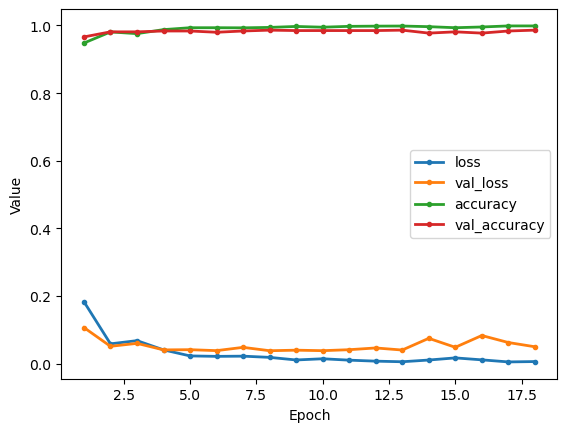

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2785,0.011811,0.003937,0.0,0.0,0.000000,0.0,0.0,0.003937,0.000000,0.003937,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1375,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.001374,0.001374,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3274,0.009804,0.000000,0.0,0.0,0.004902,0.0,0.0,0.000000,0.000000,0.000000,...,0.004902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2215,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003891
3015,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8730)
X_test: (1000, 8730)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,235,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,278,401 (8.69 MB)

 Trainable params: 2,278,401 (8.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - accuracy: 0.4688 - loss: 0.6931

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4774 - loss: 0.6931   

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5138 - loss: 0.6924

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5725 - loss: 0.6904

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6163 - loss: 0.6865

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6515 - loss: 0.6790

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6800 - loss: 0.6668

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6831 - loss: 0.6650 - val_accuracy: 0.9800 - val_loss: 0.1829


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.1843

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.1504 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9963 - loss: 0.1273

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9953 - loss: 0.1114

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9946 - loss: 0.0999

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9942 - loss: 0.0901

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9941 - loss: 0.0824 - val_accuracy: 0.9987 - val_loss: 0.0059


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0025

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9950 - loss: 0.0118 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9955 - loss: 0.0115

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9960 - loss: 0.0109

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9963 - loss: 0.0105

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.0105

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0103 - val_accuracy: 0.9975 - val_loss: 0.0065


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0012

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0037 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0046

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0046

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0045

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0043

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0042 - val_accuracy: 0.9975 - val_loss: 0.0078


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0138

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9954 - loss: 0.0046 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0034

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0028

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0025

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0024

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9984 - loss: 0.0023

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9984 - loss: 0.0023

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9984 - loss: 0.0023

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9985 - loss: 0.0022

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9985 - loss: 0.0022

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9985 - loss: 0.0022 - val_accuracy: 0.9975 - val_loss: 0.0056


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 1.8537e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7557e-04 

12/50 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.0081e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.0054e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 4.9888e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 4.9630e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 4.9380e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 4.8838e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 4.8444e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.7659e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.6710e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.6287e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.6206e-04 - val_accuracy: 0.9987 - val_loss: 0.0029


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.4362e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8249e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8035e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6448e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7342e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8027e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8258e-04 - val_accuracy: 0.9987 - val_loss: 0.0031


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.1777e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1138e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0133e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9533e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0158e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0522e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0612e-04 - val_accuracy: 1.0000 - val_loss: 0.0027


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.1601e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1563e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2566e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3529e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5455e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6548e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7089e-04 - val_accuracy: 0.9987 - val_loss: 0.0030


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.6787e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5219e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8079e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1716e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2781e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2846e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2771e-04 - val_accuracy: 0.9987 - val_loss: 0.0033


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.8265e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4952e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6762e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5562e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0178e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0386e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0456e-04 - val_accuracy: 0.9987 - val_loss: 0.0024


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.4331e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3603e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1274e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0141e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4787e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0192e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8289e-05 - val_accuracy: 1.0000 - val_loss: 0.0023


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.4809e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2059e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4669e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9939e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2699e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5914e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7613e-05 - val_accuracy: 0.9987 - val_loss: 0.0022


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.2815e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4696e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6519e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2561e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9918e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7569e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6528e-05 - val_accuracy: 1.0000 - val_loss: 0.0022


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 5.3454e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7322e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9970e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2402e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2177e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3214e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.3873e-05 - val_accuracy: 0.9987 - val_loss: 0.0021


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 9.9221e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0299e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0196e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7844e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6438e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5036e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4294e-05 - val_accuracy: 1.0000 - val_loss: 0.0022


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.1533e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8152e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7113e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5619e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6902e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6880e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6808e-05 - val_accuracy: 1.0000 - val_loss: 0.0021


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.2730e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6135e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4284e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4250e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4407e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4884e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4984e-05 - val_accuracy: 1.0000 - val_loss: 0.0020



[Train Accuracy: 100.00% - Test Accuracy: 99.90%]


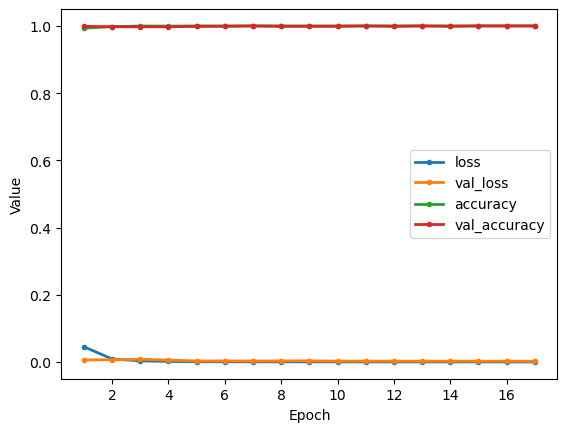

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYV,YYYX,YYYY
2785,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003953,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1375,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274,0.004926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2215,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.003906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3015,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,379,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,420,609 (138.93 MB)

 Trainable params: 36,420,609 (138.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 30s 620ms/step - accuracy: 0.4531 - loss: 0.6932

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.4531 - loss: 0.6932 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.4705 - loss: 0.6931

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.4808 - loss: 0.6931

 5/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4853 - loss: 0.6931

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4890 - loss: 0.6931

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4966 - loss: 0.6930

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5066 - loss: 0.6930

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5161 - loss: 0.6929

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5234 - loss: 0.6928

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5296 - loss: 0.6927

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5343 - loss: 0.6926

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5389 - loss: 0.6925

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5439 - loss: 0.6924

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5489 - loss: 0.6923

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5537 - loss: 0.6922

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5587 - loss: 0.6920

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5640 - loss: 0.6919

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5695 - loss: 0.6917

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5750 - loss: 0.6915

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5805 - loss: 0.6913

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5859 - loss: 0.6910

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5913 - loss: 0.6908

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5967 - loss: 0.6905

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6021 - loss: 0.6902

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6074 - loss: 0.6898

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6127 - loss: 0.6895

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6178 - loss: 0.6891

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6229 - loss: 0.6887

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6278 - loss: 0.6882

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.6327 - loss: 0.6878

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.6374 - loss: 0.6872

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.6421 - loss: 0.6866

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6466 - loss: 0.6860

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6511 - loss: 0.6853

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6554 - loss: 0.6846

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6596 - loss: 0.6839

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6637 - loss: 0.6831

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6678 - loss: 0.6822

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6717 - loss: 0.6813

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6755 - loss: 0.6803

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6793 - loss: 0.6793

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6830 - loss: 0.6782

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6866 - loss: 0.6771

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6900 - loss: 0.6758

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6934 - loss: 0.6746

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6968 - loss: 0.6733

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7000 - loss: 0.6719

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7031 - loss: 0.6705

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7062 - loss: 0.6690

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.7092 - loss: 0.6676 - val_accuracy: 0.9962 - val_loss: 0.2707


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 1.0000 - loss: 0.2650

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.2543 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9983 - loss: 0.2514

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9977 - loss: 0.2471

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9976 - loss: 0.2421

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9975 - loss: 0.2376

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9976 - loss: 0.2329

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9971 - loss: 0.2288

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9969 - loss: 0.2244

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9967 - loss: 0.2201

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9965 - loss: 0.2161

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9962 - loss: 0.2125

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9961 - loss: 0.2090

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9960 - loss: 0.2055

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9958 - loss: 0.2021

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9956 - loss: 0.1988

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9954 - loss: 0.1956

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9953 - loss: 0.1925

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9952 - loss: 0.1894

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9951 - loss: 0.1864

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9951 - loss: 0.1835

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9950 - loss: 0.1806

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9950 - loss: 0.1779

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9950 - loss: 0.1752

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9950 - loss: 0.1726

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9950 - loss: 0.1701

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9950 - loss: 0.1676

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9950 - loss: 0.1653

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9950 - loss: 0.1630

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9950 - loss: 0.1608

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9950 - loss: 0.1586

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9950 - loss: 0.1565

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9950 - loss: 0.1545

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9950 - loss: 0.1525

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9950 - loss: 0.1506

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9950 - loss: 0.1487

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9950 - loss: 0.1469

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9950 - loss: 0.1451

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9950 - loss: 0.1434

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9950 - loss: 0.1417

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9950 - loss: 0.1401

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9950 - loss: 0.1385

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9951 - loss: 0.1369

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9951 - loss: 0.1354

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9951 - loss: 0.1340

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9951 - loss: 0.1325

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9951 - loss: 0.1311

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9951 - loss: 0.1298

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9951 - loss: 0.1284

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9951 - loss: 0.1271

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9951 - loss: 0.1259 - val_accuracy: 0.9925 - val_loss: 0.0169


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 1.0000 - loss: 0.0022

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 0.0033 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 0.0037

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9990 - loss: 0.0060

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9986 - loss: 0.0069

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9980 - loss: 0.0077

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9976 - loss: 0.0082

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9974 - loss: 0.0084

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9973 - loss: 0.0084

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9973 - loss: 0.0084

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9973 - loss: 0.0084

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9973 - loss: 0.0084

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9973 - loss: 0.0083

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9973 - loss: 0.0083

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9974 - loss: 0.0082

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9974 - loss: 0.0081

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9975 - loss: 0.0081

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9975 - loss: 0.0080

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9976 - loss: 0.0080

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9976 - loss: 0.0079

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9976 - loss: 0.0078

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9977 - loss: 0.0077

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9977 - loss: 0.0077

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9978 - loss: 0.0076

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9978 - loss: 0.0075

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9978 - loss: 0.0074

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9979 - loss: 0.0073

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9979 - loss: 0.0073

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9979 - loss: 0.0072

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9980 - loss: 0.0071

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9980 - loss: 0.0070

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9980 - loss: 0.0070

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9981 - loss: 0.0069

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9981 - loss: 0.0068

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9981 - loss: 0.0068

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9982 - loss: 0.0067

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9982 - loss: 0.0066

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9982 - loss: 0.0066

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9982 - loss: 0.0065

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9983 - loss: 0.0065

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9983 - loss: 0.0064

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9983 - loss: 0.0064

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9983 - loss: 0.0063

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9984 - loss: 0.0062

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9984 - loss: 0.0062

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9984 - loss: 0.0061

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9984 - loss: 0.0061

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9984 - loss: 0.0060

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9985 - loss: 0.0060

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9985 - loss: 0.0059

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 0.9987 - val_loss: 0.0062


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 1.0000 - loss: 0.0012

 2/50 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 1.0000 - loss: 0.0013 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0013

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 0.0013

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0013

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0013

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0013

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0012

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0012

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0012

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0012

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0012

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0012

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0012

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0012

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0012

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0012

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0012

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0012

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0012

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0012

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0012

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0012

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0012

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0011

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0011

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0011

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0011

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 0.0011

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0011

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0011

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0011

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0011

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0011

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0011

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9962 - val_loss: 0.0091


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 1.0000 - loss: 7.2387e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 6.6953e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 6.3639e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 6.0501e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 5.7972e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 5.5988e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.7727e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.8595e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.8987e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.9054e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 5.9021e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.8888e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.8893e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.9045e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.9056e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.9023e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.9433e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.9749e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.9912e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 6.0089e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 6.0212e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 6.0285e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 6.0338e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 6.0327e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0336e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0328e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0303e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0251e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0172e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0124e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0089e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 6.0044e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.9977e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 5.9884e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.9766e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.9631e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.9495e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.9356e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.9217e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.9073e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 5.8918e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.8751e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.8576e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.8402e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 5.8220e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.8034e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.7857e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.7678e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.7498e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 5.7318e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 5.7144e-04 - val_accuracy: 0.9975 - val_loss: 0.0065


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 4.3419e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 3.6522e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 3.2593e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 3.1954e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 3.1937e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 3.1541e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 3.1333e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 3.0808e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.0290e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 2.9816e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 2.9346e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.8916e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.8498e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 2.8122e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 2.8158e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 2.8214e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.8247e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.8303e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.8322e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.8325e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.8347e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.8340e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.8606e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.8819e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.8989e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.9132e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.9261e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.9365e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.9481e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.9595e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.9693e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.9762e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.9809e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.9837e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.9867e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.9963e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 3.0065e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 3.0164e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 3.0249e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 3.0337e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 3.0412e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0475e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.0566e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.0644e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.0718e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.0782e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.0845e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.0898e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.0942e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.0983e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 3.1023e-04 - val_accuracy: 0.9987 - val_loss: 0.0040


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 1.7772e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 1.6071e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.5403e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 1.5063e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.4825e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 1.5102e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.5263e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.5316e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.5415e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.5493e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.5617e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.5754e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.5828e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.5932e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.6065e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.6151e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.6203e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.6278e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.6357e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.6424e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.6518e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.6581e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.6649e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.6707e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.6745e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.6787e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.6827e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.6860e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.6891e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.6907e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7088e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7245e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7385e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7508e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7614e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7705e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7788e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7859e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7915e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7960e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7994e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.8020e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.8040e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.8051e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.8062e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.8068e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8070e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8070e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8065e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.8061e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.8056e-04 - val_accuracy: 0.9987 - val_loss: 0.0035


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 1.4343e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 1.3431e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 1.3180e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.2652e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.4295e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.5326e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.5832e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 1.6031e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.6122e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.6140e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.6059e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 1.5997e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.5885e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 1.5791e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.5679e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.5565e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.5459e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.5343e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.5217e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.5103e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.5001e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.4894e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.4791e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.4706e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4619e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4547e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4492e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4436e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4375e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4330e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4285e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4234e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.4195e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.4151e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.4110e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.4067e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.4025e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.3985e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.3942e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.3898e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.3851e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.3825e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.3795e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.3768e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.3740e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.3714e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.3686e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.3659e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 1.3631e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.3603e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3576e-04 - val_accuracy: 0.9987 - val_loss: 0.0050


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 1.0000 - loss: 8.6872e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 8.3553e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 7.8803e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 7.5056e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 7.3249e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 7.5879e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 7.6925e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 7.7260e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 7.7254e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 7.6942e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.7119e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.6957e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.7042e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.7015e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.7226e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.7458e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.7957e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.8369e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.8676e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.9011e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.9349e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.9555e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.9800e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.9952e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.0109e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.0245e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.1009e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.1689e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.2299e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.2823e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.3261e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.3648e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 8.3980e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 8.4234e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 8.4441e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 8.4632e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 8.4791e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 8.4942e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 8.5083e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 8.5228e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 8.5344e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 8.5427e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 8.5496e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 8.5545e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 8.5575e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 8.5609e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 8.5616e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 8.5661e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 8.5685e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 8.5693e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 8.5701e-05 - val_accuracy: 0.9987 - val_loss: 0.0042


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 1.0000 - loss: 4.6014e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 5.1020e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 5.3101e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 5.4070e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.3234e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 5.3483e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 5.3665e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.4072e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.5083e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.5597e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.5756e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.6033e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.6267e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 5.7972e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.9277e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 6.0246e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 6.1035e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 6.1628e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 6.2087e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 6.2457e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 6.2711e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 6.2910e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 6.3065e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 6.3234e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.3344e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 6.3668e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.3910e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 6.4126e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.4288e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.4496e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.4661e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.4776e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.4900e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.4980e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.5034e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.5092e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.5242e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.5380e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.5500e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.5605e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.5695e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.5762e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.5803e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.5841e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.5937e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.6011e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 6.6074e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 6.6120e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 6.6156e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 6.6193e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.6229e-05 - val_accuracy: 0.9975 - val_loss: 0.0056


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 1.0000 - loss: 7.6752e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 7.4016e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 6.9157e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 6.5657e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 6.2455e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.9624e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.7263e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.5539e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.3979e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.2525e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.1292e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.0799e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.0277e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.9751e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.9776e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.9713e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.9555e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.9373e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.9168e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.8946e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.8860e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.8753e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.8617e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 4.8476e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.8359e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.8223e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 4.8104e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.7966e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.7806e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.7664e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.7535e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.7396e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.7266e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.7167e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.7063e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.6991e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 4.6906e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 4.6826e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 4.6904e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 4.6961e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.7075e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 4.7188e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 4.7286e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 4.7379e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 4.7484e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 4.7643e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 4.7815e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 4.7980e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 4.8129e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 4.8269e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8404e-05 - val_accuracy: 0.9987 - val_loss: 0.0041


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 1.0000 - loss: 1.5973e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.3444e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.2150e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 1.1128e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 1.0435e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 9.9756e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 9.5461e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 9.1620e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 8.8196e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.5450e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.3222e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.1355e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.0115e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.8993e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.7889e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.6781e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.5744e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.4740e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 7.3893e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 7.3164e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 7.2458e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 7.1820e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 7.1211e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 7.0604e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 7.0011e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.9931e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.9789e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.9651e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.9459e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.9249e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.9031e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.8783e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 6.8522e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.8243e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 6.7951e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 6.7645e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 6.7323e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 6.7010e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 6.6713e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 6.6406e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 6.6108e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.5801e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.5499e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.5198e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.4894e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.4588e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.4276e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.3965e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.3661e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 6.3359e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.3068e-05 - val_accuracy: 0.9975 - val_loss: 0.0069


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 1.0000 - loss: 3.2745e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 3.1740e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.0033e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 3.0065e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.3464e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 3.5355e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.5992e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 3.6509e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.6770e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 3.7358e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.7689e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.7826e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.7926e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.8009e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 3.8071e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 3.8113e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 3.8081e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.8072e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 3.8022e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 3.7948e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.7902e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.7821e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.7719e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.7597e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 3.7600e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.7566e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.7502e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.7419e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 3.7329e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7229e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.7120e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.6998e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 3.6876e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6827e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.6777e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6727e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6683e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6630e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6576e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6518e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6451e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 3.6382e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.6312e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.6236e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.6160e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.6111e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.6068e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.6019e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.5969e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5942e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.5917e-05 - val_accuracy: 0.9975 - val_loss: 0.0052



[Train Accuracy: 100.00% - Test Accuracy: 99.90%]


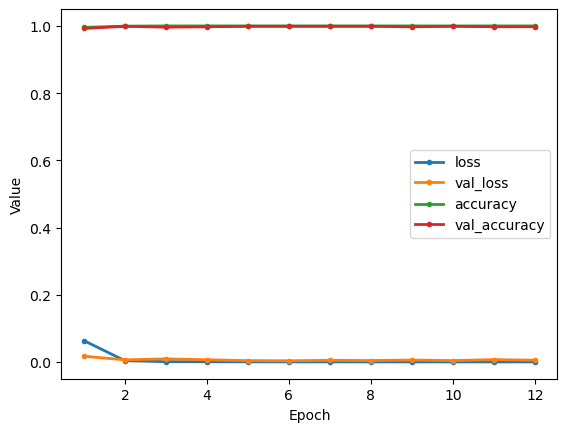

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [26]:
report.save()

Report saved as Output/Reports/HD-ZIP/report_FERAC6DP.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [28]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [30]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [31]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [32]:
# END

In [33]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################